Задание №2 (Часть 2)
--
Выполнила: Соболева Дарья 
--
Студентка 317 группы ВМК МГУ
--
Версия Python: 3.5
--

In [1]:
import time
import numpy as np
import pandas as pd
#from collections import Counter
from sklearn.datasets import fetch_20newsgroups
from scipy.sparse import csr_matrix
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer

from nearest_neighbors import KNN_classifier
from cross_validation import kfold, knn_cross_val_score, accuracy_score
from plt_confusion_matrix import plot_confusion_matrix

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Загрузим детасет 20newgroups.

Уберем все заголовки, подписи и цитаты.

In [2]:
train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

In [3]:
corpus_size = len(train.data)
corpus_size

11314

Приведем все буквы в нижний регистр.
Заменим символы, неявляющиеся буквами и цифрами на пробелы.

In [4]:
new_train = []
convert = lambda x: x if str.isalnum(x) else ' '
for doc in train.data:
    new_train.append(''.join([convert(ch) for ch in str.lower(doc)]))

Разобъем каждый документ на термы по пробельным символам

In [5]:
tokens_train = []
for doc in new_train:
    tokens_train.append(doc.split())

Преобразуем детасет в разреженную матрицу.

In [6]:
indptr = [0]
indices = []
data = []

tokens = {}
token_n = 0

for doc_t in tokens_train:
    for w in doc_t:
        if w not in tokens:
            tokens[w] = token_n
            token_n += 1
            
        indices.append(tokens[w])
        data.append(1)
        
    indptr.append(len(indices))
sparse_train = csr_matrix((np.array(data), np.array(indices), np.array(indptr)),
                           shape=(len(tokens_train), len(tokens)))

Оценим по кросс-валидации с 3 фолдами долю правильных ответов  и скорость метода k ближайших соседей в зависимости от:
* параметра k (число ближайших соседей). Диапазон изменения: [1, 10]
* используемой метрики, по которой считается расстояние между объектами.
Рассматриваемые метрики: {'euclidean', 'cosine'}.
    
* используется ли взвешенный метод k ближайших соседей

Покажем на графиках зависимость accuracy (среднее по фолдам) от параметра k, для каждой рассматриваемой метрики.

Сравнительный анализ моделей с разными метриками представлен в виде таблицы (оцениваем время работы и долю правильных ответов).

Проведем оценку параметров на модели 'brute' (деревья не работают с разреженными матрицами, а 'my_own' будет давать похожие результаты).

Это можно объяснить тем, что объекты, представленные в разреженной матрице, сильно удалены друг от друга.
Кроме того в нашей задаче признаковое пространство имеет очень высокую размерность, а значит,
не имеет смысла использовать методы 'kd_tree' и 'ball_tree'.
Они просто перестают быть эффективными ("Проклятие размерности")

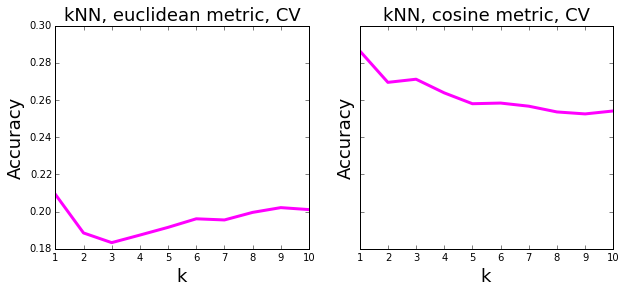

In [7]:
scores = {}
metrics = {"euclidean", "cosine"}
k_list = list(range(1,11))


time_list = []
best_res = []
f, (ax1, ax2) = subplots(1, 2, sharey=True, figsize = (10,4))

for metric, ax in zip (metrics, [ax1, ax2]):
    ax.set_title('kNN, {} metric, CV'.format(metric), fontsize=18)
    ax.set_xlim([1, max(k_list)])
    ax.set_xticks(np.arange(min(k_list), max(k_list)+1, 1))
    ax.set_xlabel("k", fontsize = 18)
    ax.set_ylabel('Accuracy', fontsize = 18)
    #ax.text(1, 2, '{} metric'.format(metric), fontsize=18, color = 'magenta')
    
    res = knn_cross_val_score(sparse_train, train.target, k_list=k_list, metric=metric)
    
    ax.plot(k_list, [np.mean(value) for key, value in res.items()], color='magenta', lw=3)

В данном эксперименте оцениваемым параметром выступало число ближайших соседей (k).

Анализируя полученные графики приходим к выводу, что необходимо рассмотреть другое признаковое пространство.

Произведем tf-idf преобразование детасета

In [8]:
vectorizer = TfidfTransformer()
vectors_train = vectorizer.fit_transform(sparse_train)

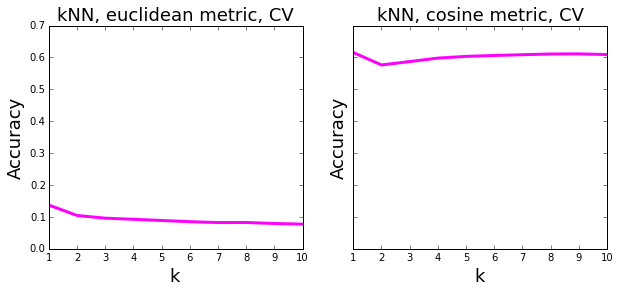

In [9]:
# Проведем оценку параметров на модели 'brute' (деревья не работают с разреженными матрицами)
scores = {}
metrics = {"euclidean", "cosine"}
k_list = list(range(1,11))


time_list = []
best_res = []
f, (ax1, ax2) = subplots(1, 2, sharey=True, figsize = (10,4))

for metric, ax in zip (metrics, [ax1, ax2]):
    ax.set_title('kNN, {} metric, CV'.format(metric), fontsize=18)
    ax.set_xlim([1, max(k_list)])
    ax.set_xticks(np.arange(min(k_list), max(k_list)+1, 1))
    ax.set_xlabel("k", fontsize = 18)
    ax.set_ylabel('Accuracy', fontsize = 18)
    #ax.text(1, 2, '{} metric'.format(metric), fontsize=18, color = 'magenta')
    
    res = knn_cross_val_score(vectors_train, train.target, k_list=k_list, metric=metric)
    
    ax.plot(k_list, [np.mean(value) for key, value in res.items()], color='magenta', lw=3)

Модель с косинусной метрикой справилась гораздо лучше модели с евклидовой метрикой. 
Действительно, косинусное расстояние является более адекватной оценкой качества в данной задаче.

Для модели с косинусной метрикой наблюдается два оптиума k=1 и k=9.

Модель с k=9 более устойчива к шуму, а значит, должна дать более высокое качество на тестовой выборке.
Соответствующая оценка будет проведена позже.

Хотелось бы провести еще больше исследований и оценить валидационную ошибку на обучении. А также рассмотреть метрику Минковского
с другим значением параметра p,
являющейся очень подходящей для пространств высокой размерности.


In [16]:
k = 9

start = time.clock()
res1 = np.mean(
    knn_cross_val_score(vectors_train, train.target, k_list=[k], metric='euclidean')[k])
time1 = time.clock() - start

start = time.clock()
res2 = np.mean(
    knn_cross_val_score(vectors_train, train.target, k_list=[k], metric='cosine')[k])
time2 = time.clock() - start

scores = {
    'kNN:"brute_euclidean"':{"Accuracy":res1, "Prediction time":time1 },
    'kNN:"brute_cosine"':{"Accuracy": res2, "Prediction time":time2}
}
pd.DataFrame(scores).T

,Accuracy,Prediction time
"kNN:""brute_cosine""",0.617377,7.556612
"kNN:""brute_euclidean""",0.081315,7.910566


Лучшей является косинусная метрика.

Сравним теперь взвешенный метод с методом без весов. Оценку моделей будем проводить на кросс-валидации (при тех же фолдах и параметрах).

In [17]:
# Возьмем за основу модель 'brute' с косинусной метрикой. (победитель предыдущих испытаний)
scores = {}

k = 9
scores = {
    'weighted kNN:"brute"':{"Accuracy": np.mean(knn_cross_val_score(vectors_train, train.target, k_list=[k],
                                                                    metric='cosine', weights=True)[k])},
    'kNN:"brute"':{"Accuracy": np.mean(knn_cross_val_score(vectors_train, train.target,
                                                            k_list = [k], metric='cosine')[k])}
}
pd.DataFrame(scores).T

,Accuracy
"kNN:""brute""",0.614989
"weighted kNN:""brute""",0.639208


Метод, использующий взвешенное голосование оказался лучшим.

---

Загрузим теперь тестовую выборку и проведем аналогичные преобразования.
Рассмотрим только те признаки, которые есть в обучающей выборке.

In [18]:
test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

new_test = []
convert = lambda x: x if str.isalnum(x) else ' '
for doc in test.data:
    new_test.append(''.join([convert(ch) for ch in str.lower(doc)]))
    
tokens_test = []
for doc in new_test:
    tokens_test.append(doc.split())
    
indptr = [0]
indices = []
data = []

for doc_t in tokens_test:
    for w in doc_t:
        if w in tokens:
            indices.append(tokens[w])
            data.append(1)
            
    indptr.append(len(indices))    
    
sparse_test = csr_matrix((np.array(data), np.array(indices), np.array(indptr)),
                         shape=(len(tokens_test), len(tokens)))
vectors_test = vectorizer.transform(sparse_test)

Оценим качество на обучающей и тестовой выборках лучшего алгоритма.

Сравним также его с моделью с k=1.

In [20]:
scores = {}
knn = KNN_classifier(
        k=1,
        metric='cosine',
        weights=True
    ).fit(vectors_train, train.target)

y_pred_test = knn.predict(vectors_test)
y_pred_train = knn.predict(vectors_train)
scores['brute_cosine_1'] = {"Accuracy_Test:": accuracy_score(test.target, y_pred_test),
                            "Accuracy_Train:": accuracy_score(train.target,y_pred_train )}

knn = KNN_classifier(
        k=9,
        metric='cosine',
        weights=True
    ).fit(vectors_train, train.target)

y_pred_test = knn.predict(vectors_test)
y_pred_train = knn.predict(vectors_train)
scores['brute_cosine_9'] = {"Accuracy_Test:": accuracy_score(test.target, y_pred_test),
                            "Accuracy_Train:": accuracy_score(train.target, y_pred_train )}
pd.DataFrame(scores).T

,Accuracy_Test:,Accuracy_Train:
brute_cosine_1,0.528943,0.974810
brute_cosine_9,0.571827,0.972689


Сравнивая качество на тестовой выборке с качеством на обучении приходим к выводу, что наша модель сильно переобучена.
Модель с k=9 лучше, но по-прежнему обладает плохой обобщающей способностью.

Качество можно улучшить, поработав с признаковым пространством (явно видна проблема "Проклятие размерности"),
а также рассмотрев другую метрику (например, метрику Минковского с другим значением параметра p).


Вернемся к нашей модели. Для начала, проанализируем объекты, на которых классифакатор совершил ошибку.

Итоговый алгоритм

In [21]:
knn = KNN_classifier(
        k=9,
        metric='cosine',
        weights=True
    ).fit(vectors_train, train.target)

y_pred = knn.predict(vectors_test)

In [22]:
# Выберем 4 случайных обьекта, на которых была допущена ошибка
n_samples = 4
idxs = np.random.choice(np.nonzero(test.target!=y_pred)[0], n_samples, replace=False)

In [60]:
ans = {}
for i in range(n_samples):
    ans['{}_object'.format(i)] = {"Predicted:": y_pred[idxs[i]],
                                  "Actual" : test.target[idxs[i]] }
pd.DataFrame(ans).T

,Actual,Predicted:
0_object,13,17
1_object,16,17
2_object,4,2
3_object,18,12


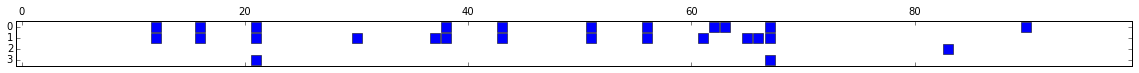

In [63]:
# Рассмотрим 100 первых признака у каждого из объектов
figure(figsize = (20,8))
spy(vectors_test[idxs][:, :100])
show()

Первый  и Второй объекты действительно похожи, однако принадлежат разным классам.

Косинусная метрика является хорошей метрикой качества, однако, пока не решена проблема с "Проклятием размерности",
качество будет плохим.

Осталось проанализировать матрицу ошибок

Confusion matrix, without normalization


/root/miniconda/envs/jupyterhub_py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


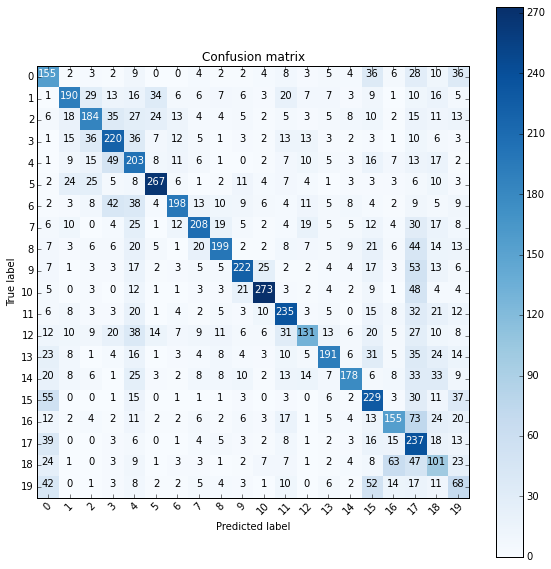

In [64]:
cnf_matrix = confusion_matrix(test.target, y_pred)
np.set_printoptions(precision=2)
figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=np.arange(len(set(train.target))),
                      title='Confusion matrix')


show()

Аналогично тому, как мы оценивали работу классифакатора на детасете MNIST:

Выберем произвольный класс, на котором посчитаем точность, полноту и F-меру.

Рассмотрим 0 класс.


In [70]:
Presicion_0cls = 0.36384976525821594
Recall_0cls = 0.48589341692789967     
F_0cls = 2*Presicion_0cls*Recall_0cls/(Presicion_0cls + Recall_0cls)
scores = {
    'Final_model':{"Presicion_5cls:": Presicion_0cls,
                   "Recall_5cls:": Recall_0cls,
                   "F_5cls:": F_0cls
    }
}
pd.DataFrame(scores).T

,F_5cls:,Presicion_5cls:,Recall_5cls:
Final_model,0.416107,0.36385,0.485893


Как видно, модель имеет низкие показатели по всем рассмотренным метрикам качества, что было предсказуемо с самого начала.

Естественно в данной задаче необходимо попробовать другое признаковое пространство, а также другую метрику качества.

----

Напоследок, хотелось бы отметить, что мы можем обучать при работе с метрическими классификаторами (в частности kNN)

При работе с метрическими классификаторами можно обучать:
* число ближайших соседей
* веса объектов
* набор эталонов (не было рассмотрено)
* метрику (Минковского с другим значением параметра p не была рассмотрена)

Однако важно понимать, что не любая модель годится под любую задачу.
Правильно подобранная модель должна показывать хорошие результаты прямо "из коробки":)
    

Многие предложенные мною методы не были рассмотрены в данной работе в виду нехватки времени. Однако полученные результаты 
являются подтверждением возможного улучшения работы модели в случае их использования.

При использовании kNN возможно огромное число эвристик, как например, использование метода окна Парзена, подробно описанного в
статье Константина Вячеславовича Воронцова. Метод хорош тем, что учитывает ширину окна, в которое попадают ближайшие соседи.

Также другой знаменитой эвристикой является метод потенциальных функций, основанный на наших знаниях о симметричности функции расстояния.

В случае наличия в выборке большого количества выбросов или шумовых объектов необходимо проводить отбор эталонных объектов (алгоритм STOLP).

А также последняя задача показала, что важным этапом является понижение размерности (Метод главных компонент, жадное добавление признаков).

В kNN практически отсутствуют параметры оптимизации, поэтому он показывает не самые высокие результаты, однако обладает
и рядом преимуществ:
* Простота реализации
* Интерпретируемость решений (case-based reasoning)

Из недостатков:
* Неустойчивость к выбросам
* Отсуствие настраиваемых параметров (как следствие низкое качество)
* Некоторые алгоритмы метода kNN хранят всю выборку целиком